# Bonus 3: Implementation of InfoGAN

## Setup

/home/mcreng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


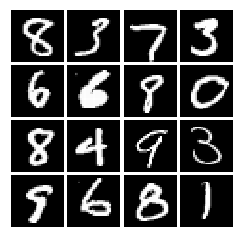

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

def leaky_relu(x, alpha=0.2):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x, alpha*x)

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], -1, 1)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Solvers

In [2]:
def get_solvers(learning_rate=2e-4, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate*10, beta1=beta1)
    Q_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver, Q_solver

## run_a_gan
With the categorical variables generation

In [3]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              Q_train_step, Q_loss, Q_extra_step, \
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        cat_ = get_one_hot(np.random.randint(low=0, high=10, size=(batch_size)), 10)
        z_ = sample_noise(batch_size, 62).eval(session=sess)
        cont_ = np.random.rand(batch_size, 2) * 2 - 1
        minibatch,minbatch_y = mnist.train.next_batch(batch_size) 
        
        feed_dict = {x: minibatch, cat: cat_, z: z_, cont: cont_, training: True}
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample, feed_dict=feed_dict)
            fig = show_images(samples[:16])
            plt.show()
            print()

        # run a batch of data through the network
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict=feed_dict)
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict=feed_dict)
        _, Q_loss_curr = sess.run([Q_train_step, Q_loss], feed_dict=feed_dict)
        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G: {:.4}, Q: {:.4}'.format(it,D_loss_curr,G_loss_curr,Q_loss_curr))
    print('Final images')
    samples = sess.run(G_sample, feed_dict=feed_dict)

    fig = show_images(samples[:16])
    plt.show()

# GAN setups
Original DCGAN with Q-Network

In [4]:
def discriminator(x, cat, cont, training=True):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, (-1, 28, 28, 1))
        conv1 = tf.layers.conv2d(x, 64, 4, 2, activation=leaky_relu)
        conv2 = tf.layers.conv2d(conv1, 128, 4, 2, activation=leaky_relu)
        bn = tf.layers.batch_normalization(conv2, training=training)
        flat = tf.layers.flatten(bn)
        fc = tf.layers.dense(flat, 1024, activation=leaky_relu)
        
        logits = tf.layers.dense(fc, 1)
    
        qfc = tf.layers.dense(fc, 128)
        qbn = tf.layers.batch_normalization(qfc, training=training)
        qbn = leaky_relu(qbn)
        q_cat = tf.layers.dense(qbn, cat, activation=tf.nn.softmax)
        
        q_cont = tf.layers.dense(qbn, cont, activation=tf.nn.tanh)

        return logits, q_cat, q_cont
    
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1, training=True)
        fc2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2, training=True)
        im = tf.reshape(bn2, (-1, 7, 7, 128))
        convt1 = tf.layers.conv2d_transpose(im, 64, (4,4), 2, 'same', activation=tf.nn.relu)
        bn3 = tf.layers.batch_normalization(convt1, training=True)
        convt2 = tf.layers.conv2d_transpose(bn3, 1, (4,4), 2, 'same', activation=tf.nn.tanh)
        img = tf.reshape(convt2, (-1, 784))
        return img


## GAN loss
With Q loss:
- Categorical vars: Negative Log Likelihood
- Continous vars: MLE

In [5]:
def gan_loss(logits_real, logits_fake, correct_cat, logits_cat, correct_cont, logits_cont):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake)
    G_loss = tf.reduce_mean(G_loss)

    D_loss1 = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)
    D_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake)
    D_loss = tf.reduce_mean(D_loss1) + tf.reduce_mean(D_loss2)
    
    Q_loss_cat = -tf.reduce_mean(tf.reduce_sum(correct_cat*tf.log(logits_cat), axis=1))
    Q_loss_cont = tf.reduce_mean(tf.reduce_sum((correct_cont - logits_cont)**2, axis=1))
    Q_loss = Q_loss_cat + Q_loss_cont
    
    return D_loss, G_loss, Q_loss

## GAN setup

In [6]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 62

number_of_categories = 10
number_of_continuous = 2

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])

z = tf.placeholder(tf.float32, [batch_size, noise_dim])
cat = tf.placeholder(tf.float32, [None, number_of_categories])
cont = tf.placeholder(tf.float32, [None, number_of_continuous])
training = tf.placeholder(tf.bool, [])

generator_input = tf.concat(axis=1, values=[z, cat, cont])
# generated images
G_sample = generator(generator_input)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real, _, _ = discriminator(preprocess_img(x), number_of_categories, number_of_continuous, training=training)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake, logits_cat, logits_cont = discriminator(G_sample, number_of_categories, number_of_continuous, training=training)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 
Q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

D_solver, G_solver, Q_solver = get_solvers()
D_loss, G_loss, Q_loss = gan_loss(logits_real, logits_fake, cat, logits_cat, cont, logits_cont)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
Q_train_step = Q_solver.minimize(Q_loss, var_list=Q_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')
Q_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

## Training

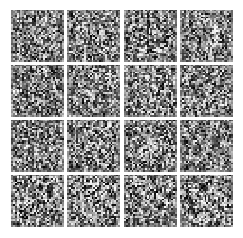


Iter: 0, D: 1.369, G: 0.9715, Q: 4.286
Iter: 50, D: 1.121, G: 2.258, Q: 2.435
Iter: 100, D: 1.508, G: 0.4963, Q: 2.544
Iter: 150, D: 1.271, G: 1.173, Q: 2.445
Iter: 200, D: 1.121, G: 1.303, Q: 2.339


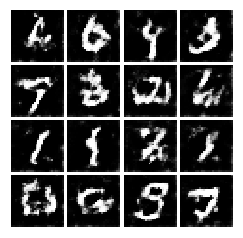


Iter: 250, D: 1.337, G: 1.597, Q: 2.192
Iter: 300, D: 1.355, G: 1.509, Q: 1.939
Iter: 350, D: 1.344, G: 1.472, Q: 1.701
Iter: 400, D: 1.475, G: 1.598, Q: 1.502
Iter: 450, D: 1.347, G: 0.7884, Q: 1.335


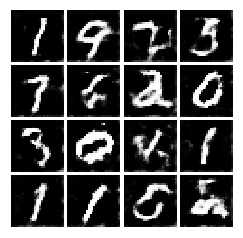


Iter: 500, D: 1.367, G: 1.687, Q: 1.253
Iter: 550, D: 1.224, G: 1.028, Q: 1.084
Iter: 600, D: 1.459, G: 1.583, Q: 1.078
Iter: 650, D: 1.221, G: 1.337, Q: 0.9042
Iter: 700, D: 1.359, G: 1.006, Q: 1.013


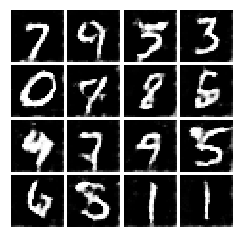


Iter: 750, D: 1.237, G: 1.004, Q: 0.9182
Iter: 800, D: 1.396, G: 1.087, Q: 0.9463
Iter: 850, D: 1.222, G: 0.9656, Q: 0.8999
Iter: 900, D: 1.317, G: 1.117, Q: 0.7695
Iter: 950, D: 1.318, G: 0.7761, Q: 0.6671


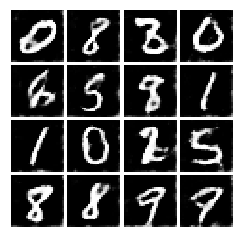


Iter: 1000, D: 1.311, G: 0.5486, Q: 0.6731
Iter: 1050, D: 1.29, G: 1.034, Q: 0.7036
Iter: 1100, D: 1.386, G: 0.8624, Q: 0.5952
Iter: 1150, D: 1.24, G: 1.01, Q: 0.6331
Iter: 1200, D: 1.461, G: 0.6261, Q: 0.5013


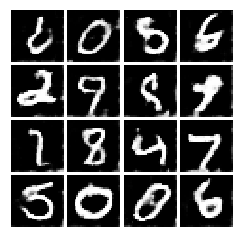


Iter: 1250, D: 1.462, G: 1.278, Q: 0.6834
Iter: 1300, D: 1.261, G: 0.9338, Q: 0.5588
Iter: 1350, D: 1.332, G: 0.9572, Q: 0.7146
Iter: 1400, D: 1.394, G: 0.7286, Q: 0.5931
Iter: 1450, D: 1.288, G: 1.03, Q: 0.5967


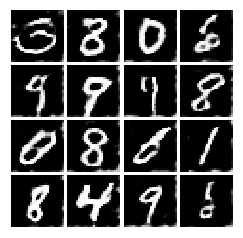


Iter: 1500, D: 1.319, G: 0.9995, Q: 0.6073
Iter: 1550, D: 1.439, G: 0.59, Q: 0.5291
Iter: 1600, D: 1.287, G: 0.8679, Q: 0.5568
Iter: 1650, D: 1.353, G: 1.019, Q: 0.587
Iter: 1700, D: 1.326, G: 0.9177, Q: 0.4622


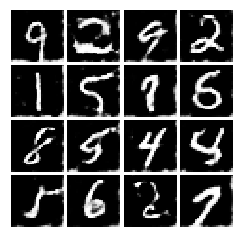


Iter: 1750, D: 1.332, G: 1.128, Q: 0.4976
Iter: 1800, D: 1.36, G: 1.036, Q: 0.5458
Iter: 1850, D: 1.317, G: 0.8224, Q: 0.4419
Iter: 1900, D: 1.411, G: 0.705, Q: 0.3116
Iter: 1950, D: 1.384, G: 0.6095, Q: 0.3851


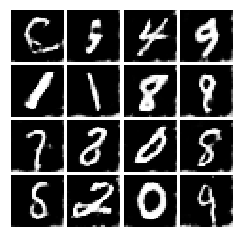


Iter: 2000, D: 1.384, G: 0.6176, Q: 0.3871
Iter: 2050, D: 1.345, G: 0.6915, Q: 0.4702
Iter: 2100, D: 1.364, G: 0.8062, Q: 0.3939
Final images


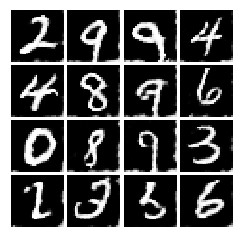

In [7]:
sess = get_session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,Q_train_step,Q_loss,Q_extra_step,num_epoch=5)

## Results
Unfortunately, I cannot recreate the results from InfoGAN. In particular, the continuous variables seem to represent something, in our case, the first one seems to represent the thickness of the bottom of 0, and the second represents whether there's a tick near the bottom of 0.

In the InfoGAN paper, the categorical variable is trained so that feeding 0 to 9 can actually output images of 0 to 9. In my model, it does not do that, it might be because GANs are generally difficult to train and the model is not broad enough. Varying the categorical variable seems to vary the style of 0 though.

Varying continous variable 1


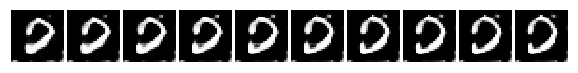

Varying continous variable 2


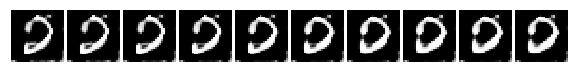

Varying categorical variable


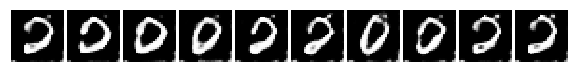

In [9]:
def my_show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return


n_sample = 128
z_ = sample_noise(batch_size, noise_dim).eval(session=sess)

images_cont1 = []

print('Varying continous variable 1')
for i in np.linspace(-1, 1, 10):
    cat_ = np.zeros(shape=[n_sample, 10])
    cont_ = np.zeros(shape=[n_sample, 2]) + [i, 0]
    samples = sess.run(G_sample, feed_dict={cat: cat_, z: z_, training: False, cont: cont_})
    images_cont1.append(samples[0])
my_show_images(np.array(images_cont1))
plt.show()

images_cont2 = []

print('Varying continous variable 2')
for i in np.linspace(-1, 1, 10):
    cat_ = np.zeros(shape=[n_sample, 10])
    cont_ = np.zeros(shape=[n_sample, 2]) + [0, i]
    samples = sess.run(G_sample, feed_dict={cat: cat_, z: z_, training: False, cont: cont_})
    images_cont2.append(samples[0])
my_show_images(np.array(images_cont2))
plt.show()

images_cat = []

print('Varying categorical variable')
for i in range(10):
    cat_ = np.zeros(shape=[n_sample, 10])
    cat_[:, i] = 1
    cont_ = np.zeros(shape=[n_sample, 2])
    samples = sess.run(G_sample, feed_dict={cat: cat_, z: z_, training: False, cont: cont_})
    images_cat.append(samples[0])
my_show_images(np.array(images_cat))
plt.show()